In [2]:
from functions.adjust_cases_functions import prepare_cases
from functions.general_utils import  get_bool
from models.seird_model import SEIRD

import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

from global_config import config

import sys


poly_run  = 11001   #int(sys.argv[1])
name_dir  = 'bogota' #str(sys.argv[2])
drop_last_weeks = True #get_bool(sys.argv[3])

print("**** Running evaluation for hist. forecast for {}".format(name_dir))

data_dir            = config.get_property('data_dir_covid')
geo_dir             = config.get_property('geo_dir')
data_dir_mnps       = config.get_property('data_dir_col')
results_dir         = config.get_property('results_dir')
agglomerated_folder = os.path.join(data_dir, 'data_stages', 'colombia', 'agglomerated', 'geometry' )

polygons = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')
polygons = polygons.loc[poly_run]

data  =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'],
                    dayfirst=True).set_index('poly_id').loc[poly_run].set_index('date_time')

data  = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)    # .rename({'smoothed_num_cases':'num_cases'})
data  = prepare_cases(data, col='num_diseased', cutoff=0) # .rename({'smoothed_num_cases':'num_cases'})
data  = data.rename(columns={'smoothed_num_cases': 'confirmed', 'smoothed_num_diseased':'death'})[['confirmed', 'death']]

print("**** **** Last day uploaded {}".format(pd.to_datetime(data.index.values[-1]).strftime('%Y-%b-%d')))

if drop_last_weeks:
    print("**** **** *** Droping last 2wk")
    data = data.iloc[:-14]

**** Running evaluation for hist. forecast for bogota
**** **** Last day uploaded 2021-May-08
**** **** *** Droping last 2wk


In [4]:
path_to_place = os.path.join(results_dir, 'weekly_forecast' , name_dir) #pd.to_datetime(data.index.values[-1]).strftime('%Y-%m-%d'))


In [22]:
dates_df = pd.DataFrame(data=os.listdir(path_to_place), columns=['date_frcst'])
dates_df = dates_df[dates_df['date_frcst'] != '.DS_Store']
dates_df["date_frcst"] = pd.to_datetime(dates_df["date_frcst"])
dates_df = dates_df.sort_values(by='date_frcst')
dates_df["path_to_frcst"] = dates_df["date_frcst"].map(lambda x: os.path.join(path_to_place, x.strftime('%Y-%m-%d') ) )


,date_frcst,path_to_frcst
11,2021-01-19,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
20,2021-01-23,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
10,2021-01-27,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
8,2021-01-29,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
14,2021-01-30,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
9,2021-02-07,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
0,2021-02-13,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
1,2021-02-14,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
12,2021-02-20,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
13,2021-02-27,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...


In [88]:
deaths_frcst_df = pd.read_csv(os.path.join(dates_df["path_to_frcst"].iloc[1], 'deaths_df.csv' ), parse_dates=["date"])
cases_frcst_df  = pd.read_csv(os.path.join(dates_df["path_to_frcst"].iloc[1], 'cases_df.csv' ), parse_dates=["date"])

deaths_frcst_df = deaths_frcst_df[deaths_frcst_df["type"]=='forecast']
cases_frcst_df = cases_frcst_df[cases_frcst_df["type"]=='forecast']

model = SEIRD(
    confirmed = data['confirmed'].cumsum(),
    death     = data['death'].cumsum(),
    T         = len(data),
    N         = int(polygons["attr_population"]),
    samples   = mcmc_samples
    )
    
def load_samples(filename):

    x = np.load(filename, allow_pickle=True)

    mcmc_samples = x['mcmc_samples'].item()
    post_pred_samples = x['post_pred_samples'].item()
    forecast_samples = x['forecast_samples'].item()

    return mcmc_samples, post_pred_samples, forecast_samples


In [253]:
def eval_ae( samples1, obs1):
    return np.mean(np.median(samples_d,0)-obs1) 

In [171]:
def compute_evals(samples_d, samples_c, obs_d, obs_c):
    

    df_response_cases = pd.DataFrame(index=list(weekdict.keys()), columns=['crps', 'mae', 'rmse'])
    df_response_deaths = pd.DataFrame(index=list(weekdict.keys()), columns=['crps', 'mae', 'rmse'])
    weekdict = {'1w':6, '2w': 13, '3w': 20, '4w': 26}
    for kw in weekdict.keys():
        w = weekdict[kw]

        df_response_deaths['crps'].loc[kw] = eval_crps( samples_d[:,:w], obs_d[:w] )
        df_response_cases['crps'].loc[kw] = eval_crps( samples_c[:,:w], obs_c[:w] )
    

        df_response_deaths['mae'].loc[kw] = eval_mae( samples_d[:,:w], obs_d[:w] )
        df_response_cases['mae'].loc[kw] = eval_mae( samples_c[:,:w], obs_c[:w] )

        df_response_deaths['rmse'].loc[kw] = eval_rmse( samples_d[:,:w], obs_d[:w] )
        df_response_cases['rmse'].loc[kw] = eval_rmse( samples_c[:,:w], obs_c[:w] )
        
    df_response_cases["type"] = 'cases'
    df_response_deaths["type"] = 'deaths'

    return pd.concat([df_response_cases, df_response_deaths])

In [180]:
from pyro.contrib.forecast import eval_crps, eval_mae, eval_rmse

import torch
import tqdm

df_stats_all = []
for idx, row in dates_df.iterrows():
    date = row["date_frcst"].strftime('%Y-%m-%d')

    try:

        mcmc_samples, post_pred_samples, forecast_samples = load_samples(os.path.join(row["path_to_frcst"], 'samples.npz'  ))
        forecast_samples['mean_dz0'] = forecast_samples["dz0"]
        forecast_samples['mean_dy0'] = forecast_samples["dy0"]
        deaths_fitted = model.combine_samples(forecast_samples, f='mean_dz', use_future=True)
        cases_fitted  = model.combine_samples(forecast_samples, f='mean_dy', use_future=True)
        dates_frcst = deaths_frcst_df["date"]
        deaths_fore = deaths_fitted[:, deaths_frcst_df.index.values]
        cases_fore  = cases_fitted[:, cases_frcst_df.index.values]
        data_eval = data.loc[dates_frcst]

        death_samples = torch.tensor(np.array(deaths_fore)); deaths_obs = torch.tensor(list(data_eval["death"].values))
        cases_samples = torch.tensor(np.array(cases_fore));  cases_obs  = torch.tensor(list(data_eval["confirmed"].values))

        df_stats = compute_evals(death_samples, cases_samples, deaths_obs, cases_obs)
        df_stats["date_forecast"] = row["date_frcst"].strftime('%Y-%m-%d')
        df_stats_all.append(df_stats)
    except:
        print(f"Samples not found for date {date}")

df_stats_resume = pd.concat(df_stats_all)
df_stats_resume.index.name = 'week'


Samples not found for date 2021-01-29
Samples not found for date 2021-03-17
Samples not found for date 2021-04-18


<ipython-input-252-f96a7407696e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_week["date_forecast"] = pd.to_datetime(df_stats_week["date_forecast"])
<ipython-input-252-f96a7407696e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_week["date_forecast"] = pd.to_datetime(df_stats_week["date_forecast"])
<ipython-input-252-f96a7407696e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



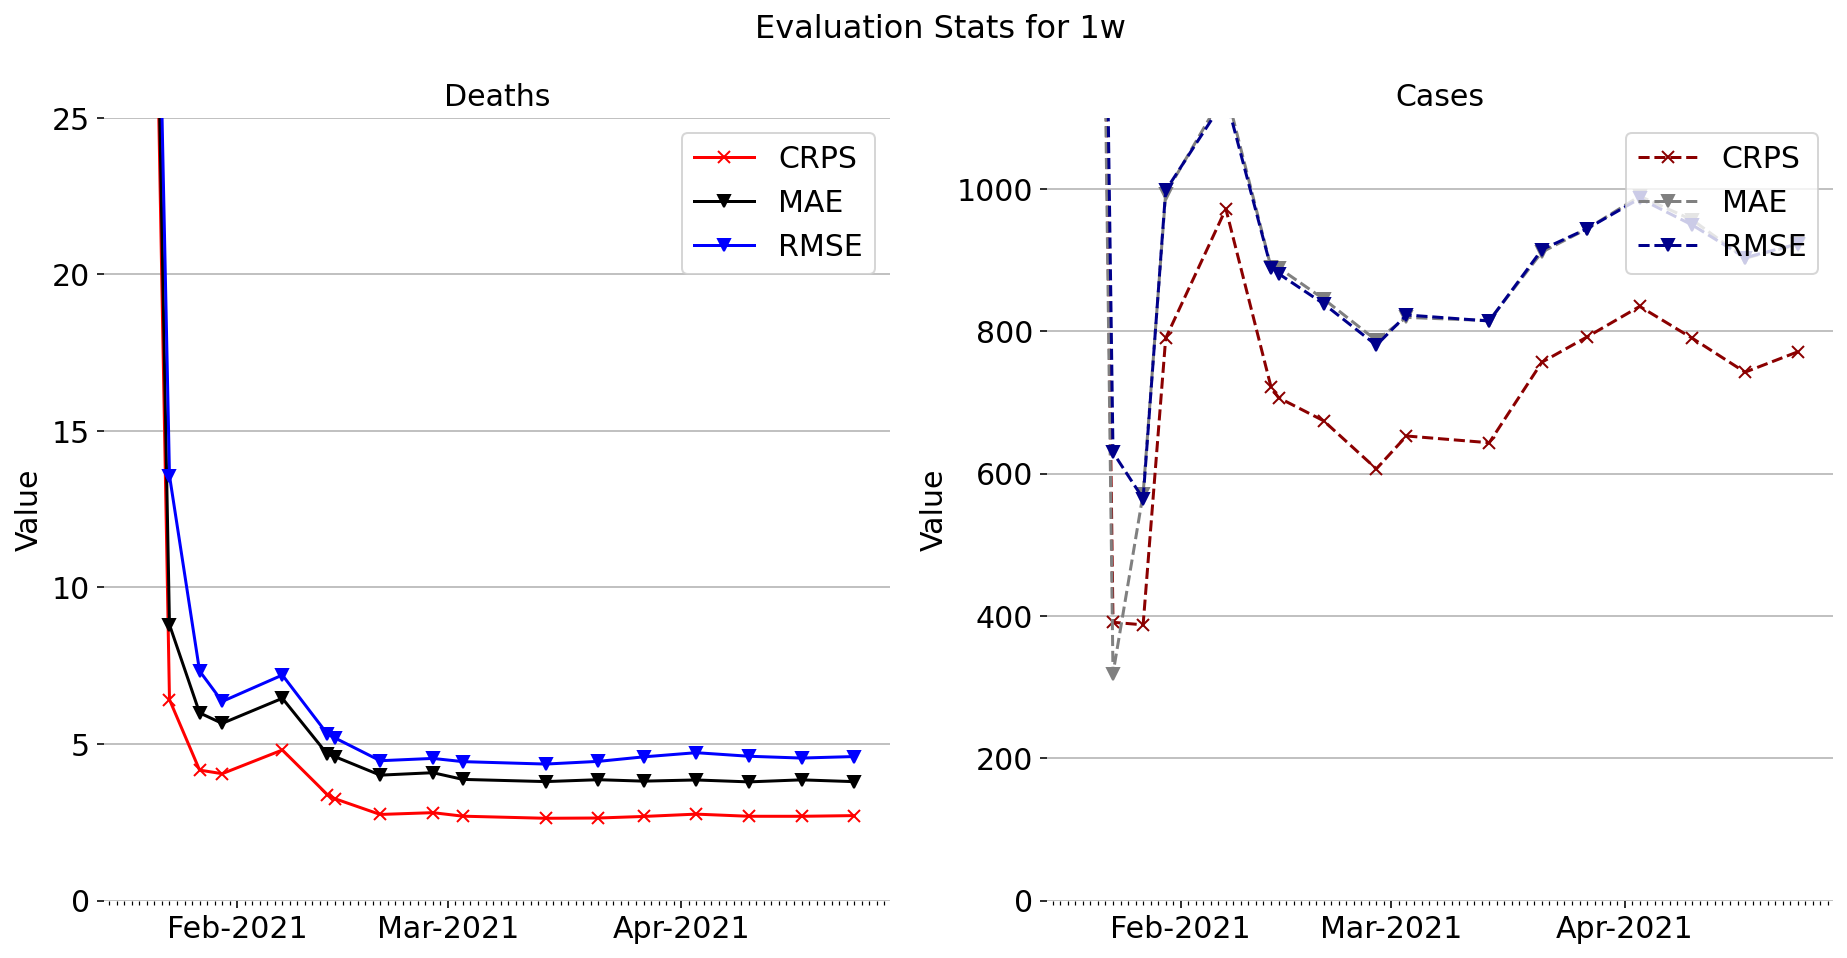

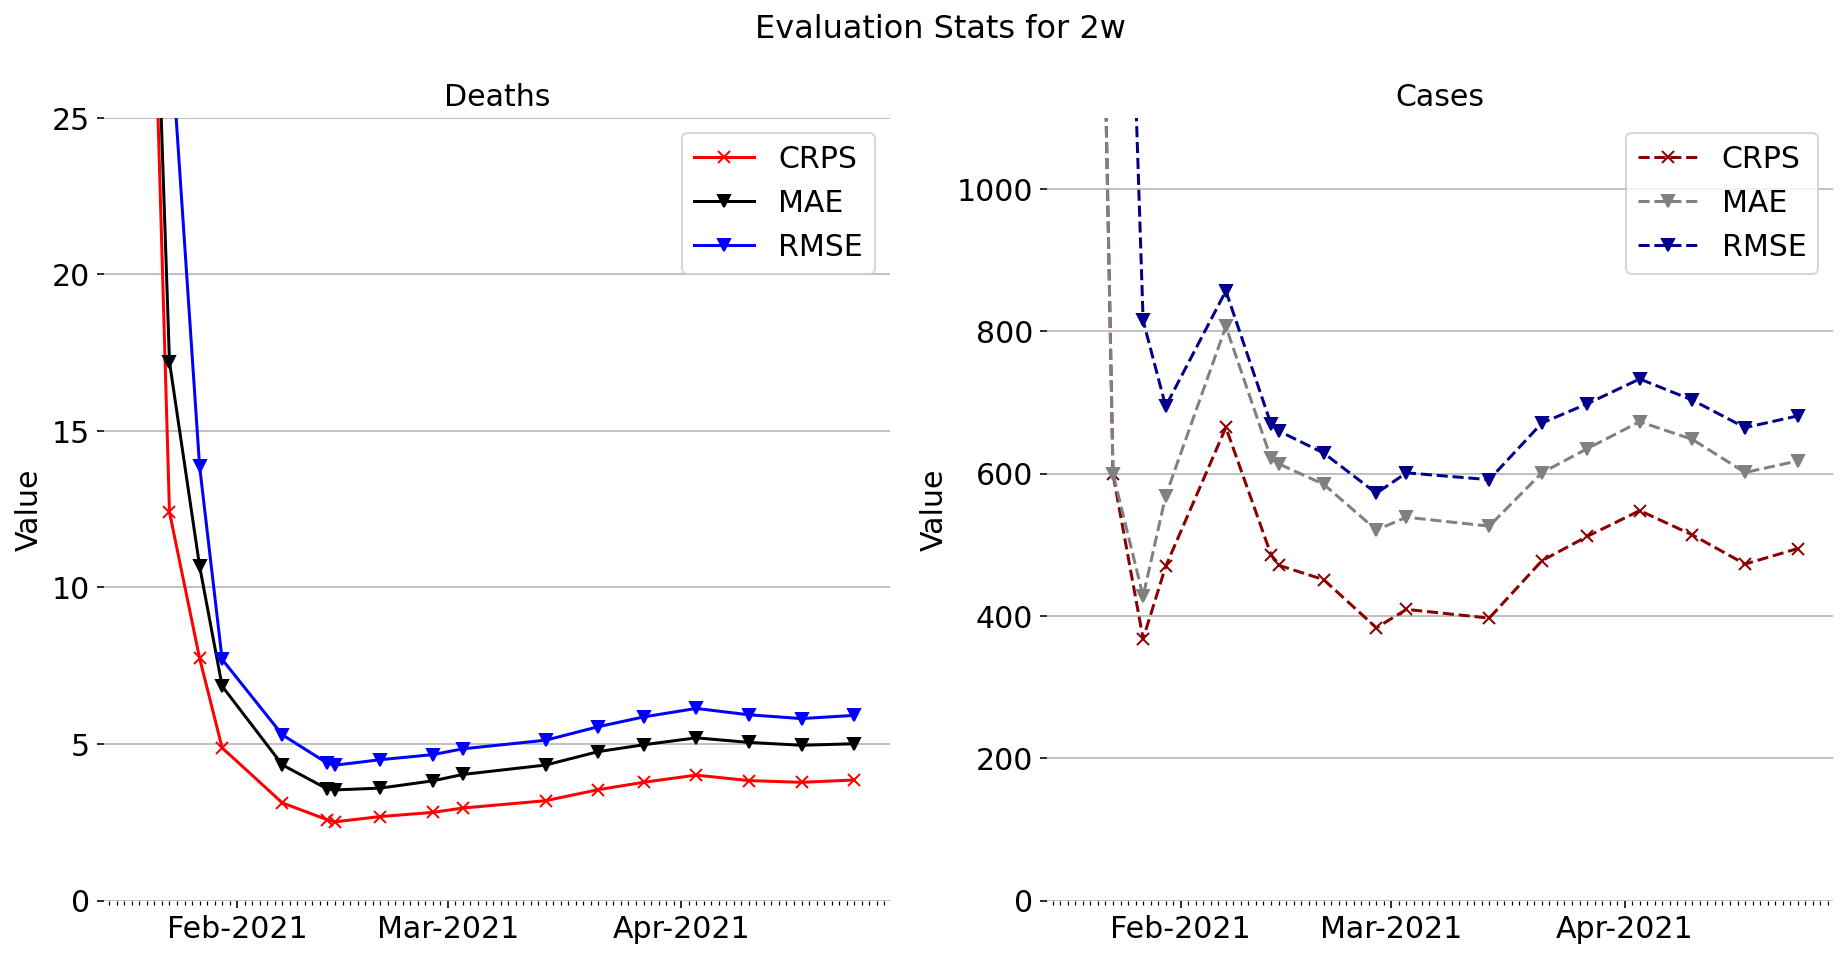

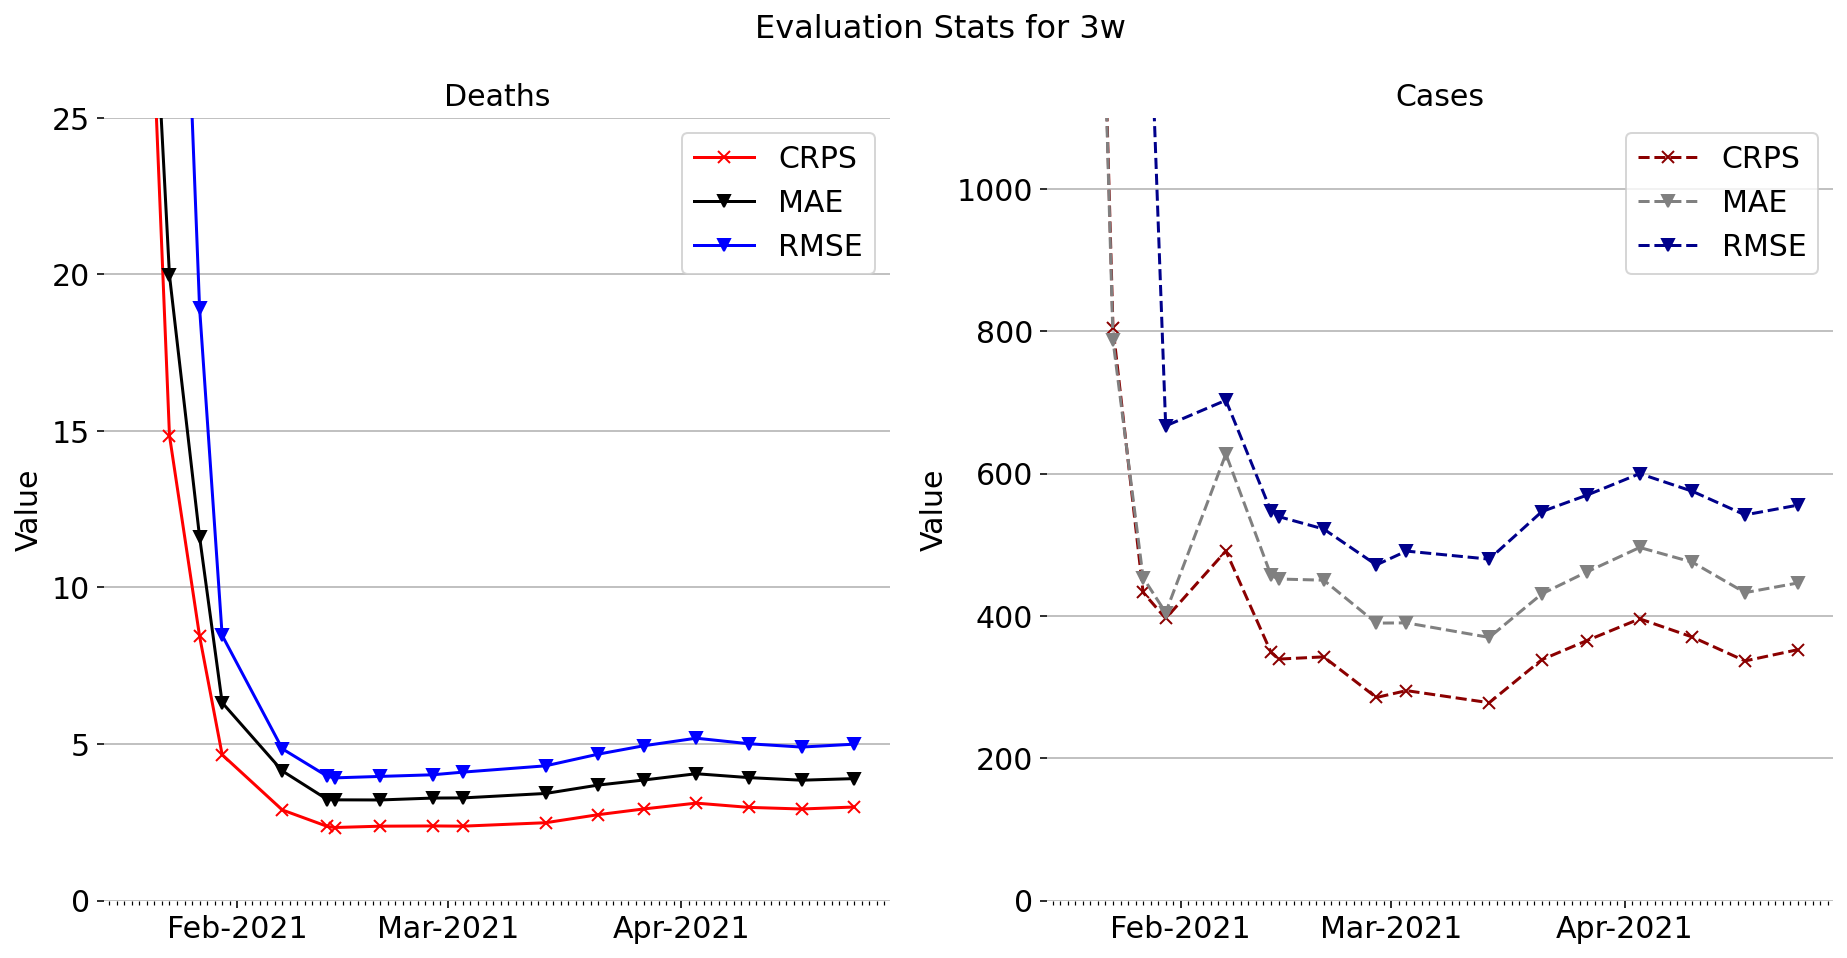

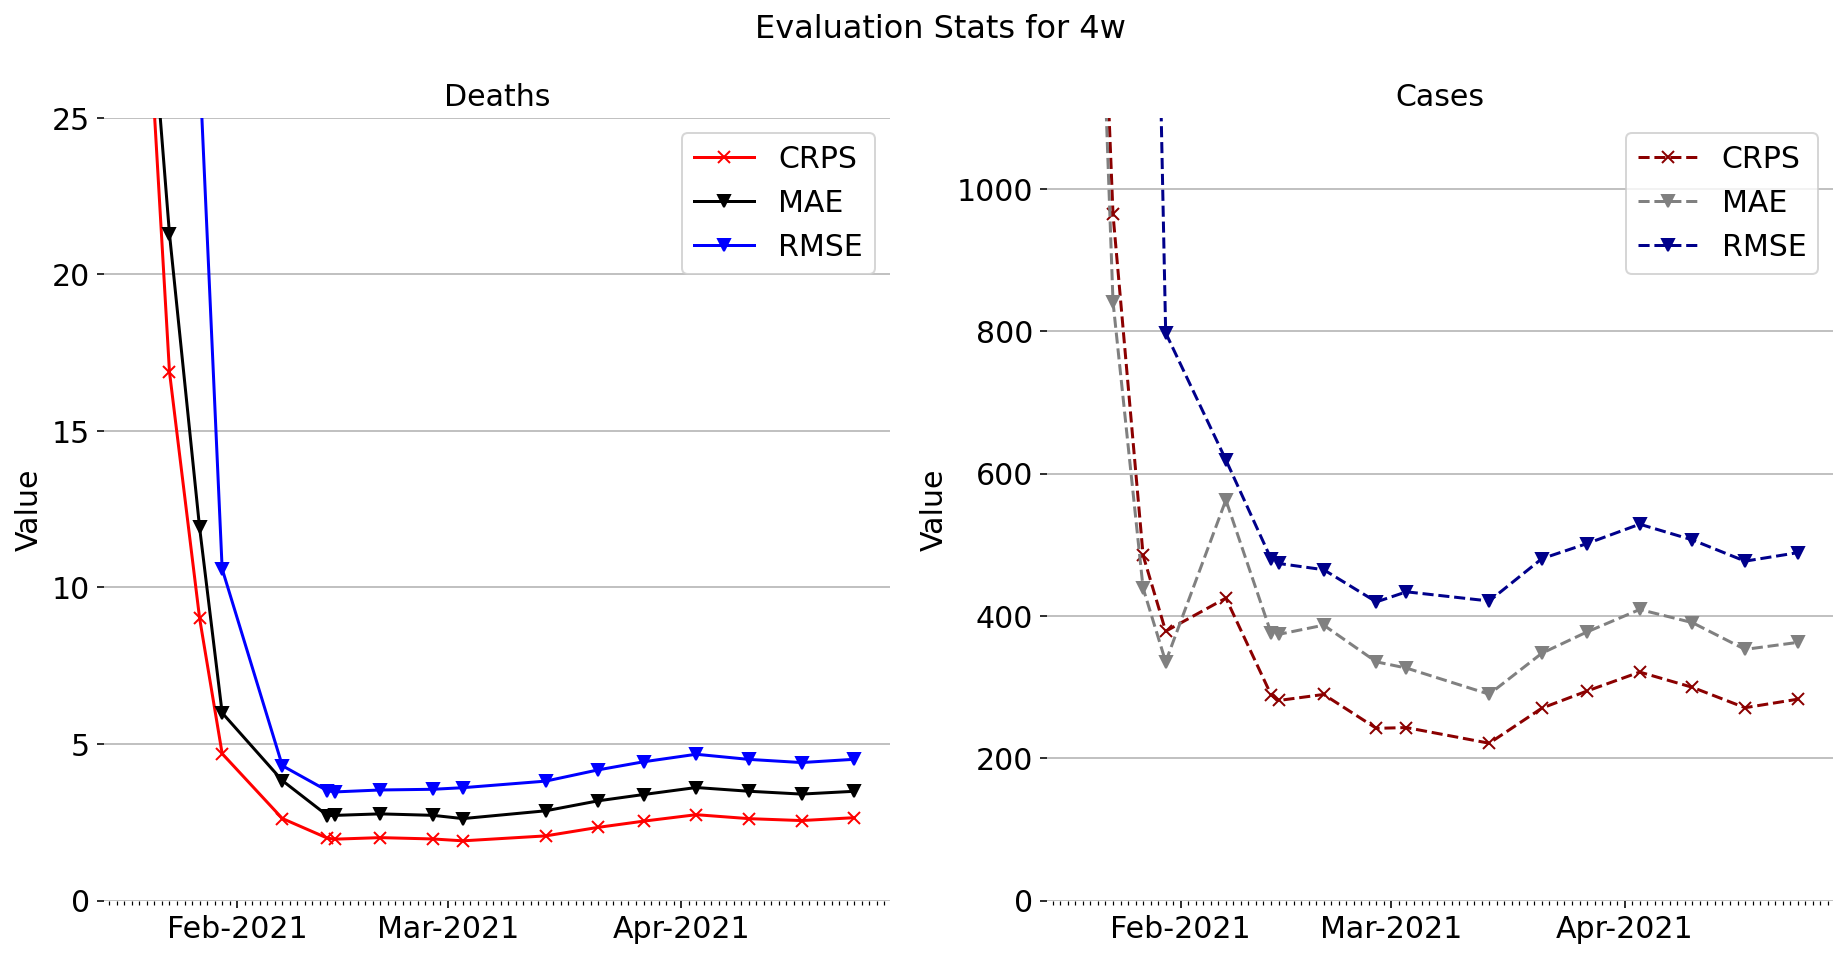

In [252]:
%config InlineBackend.figure_format ='retina'
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker


weekdict = {'1w':6, '2w': 13, '3w': 20, '4w': 26}
for kw in weekdict.keys():
    df_stats_week = df_stats_resume.loc[kw]
    df_stats_week["date_forecast"] = pd.to_datetime(df_stats_week["date_forecast"])
    df_stats_week_d = df_stats_week[df_stats_week["type"]=='deaths']
    df_stats_week_c = df_stats_week[df_stats_week["type"]=='cases']

    df_stats_week_d

    fig, axes = plt.subplots(1, 2, figsize=(15.5, 7.2)) #, sharex=True)
    axes[0].plot(df_stats_week_d["date_forecast"], df_stats_week_d["crps"], color='r', marker='x', label='CRPS')
    axes[0].plot(df_stats_week_d["date_forecast"], df_stats_week_d["mae"], color='k', marker='v', label='MAE')
    axes[0].plot(df_stats_week_d["date_forecast"], df_stats_week_d["rmse"], color='b', marker='v', label='RMSE')

    axes[1].plot(df_stats_week_c["date_forecast"], df_stats_week_c["crps"], color='darkred', marker='x', label='CRPS', linestyle='--')
    axes[1].plot(df_stats_week_c["date_forecast"], df_stats_week_c["mae"], color='gray', marker='v', label='MAE', linestyle='--')
    axes[1].plot(df_stats_week_c["date_forecast"], df_stats_week_c["rmse"], color='darkblue', marker='v', label='RMSE', linestyle='--')

    axes[0].set_title('Deaths', fontsize=15)
    axes[1].set_title('Cases', fontsize=15)

    axes[0].legend()
    axes[1].legend()
    for ax in axes:
        #ax.set_yscale('log')

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.grid(which='major', axis='y', c='k', alpha=.3, zorder=-2)
        ax.grid(which='minor', axis='y', c='k', alpha=.1, zorder=-2)

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
        ax.yaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:.0f}"))
        ax.set_ylabel('Value', size=15)
        ax.tick_params(which='both', axis='both', labelrotation=0, labelsize=15)
        ax.legend(loc='upper right', fontsize=15)

    axes[0].set_ylim( (0, 25) )
    axes[1].set_ylim( (0, 1100) )

    fig.suptitle(f"Evaluation Stats for {kw}", fontsize=16)
    fig.savefig(os.path.join('figures_eval', f'eval_{kw}.png'), dpi=300, bbox_inches='tight', transparent=False)


In [246]:

data  =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'],
                    dayfirst=True).set_index('poly_id').loc[poly_run].set_index('date_time')

data  = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)    # .rename({'smoothed_num_cases':'num_cases'})
data  = prepare_cases(data, col='num_diseased', cutoff=0) # .rename({'smoothed_num_cases':'num_cases'})
data_eval_plt = data.loc[pd.to_datetime('2021-01-19'):]


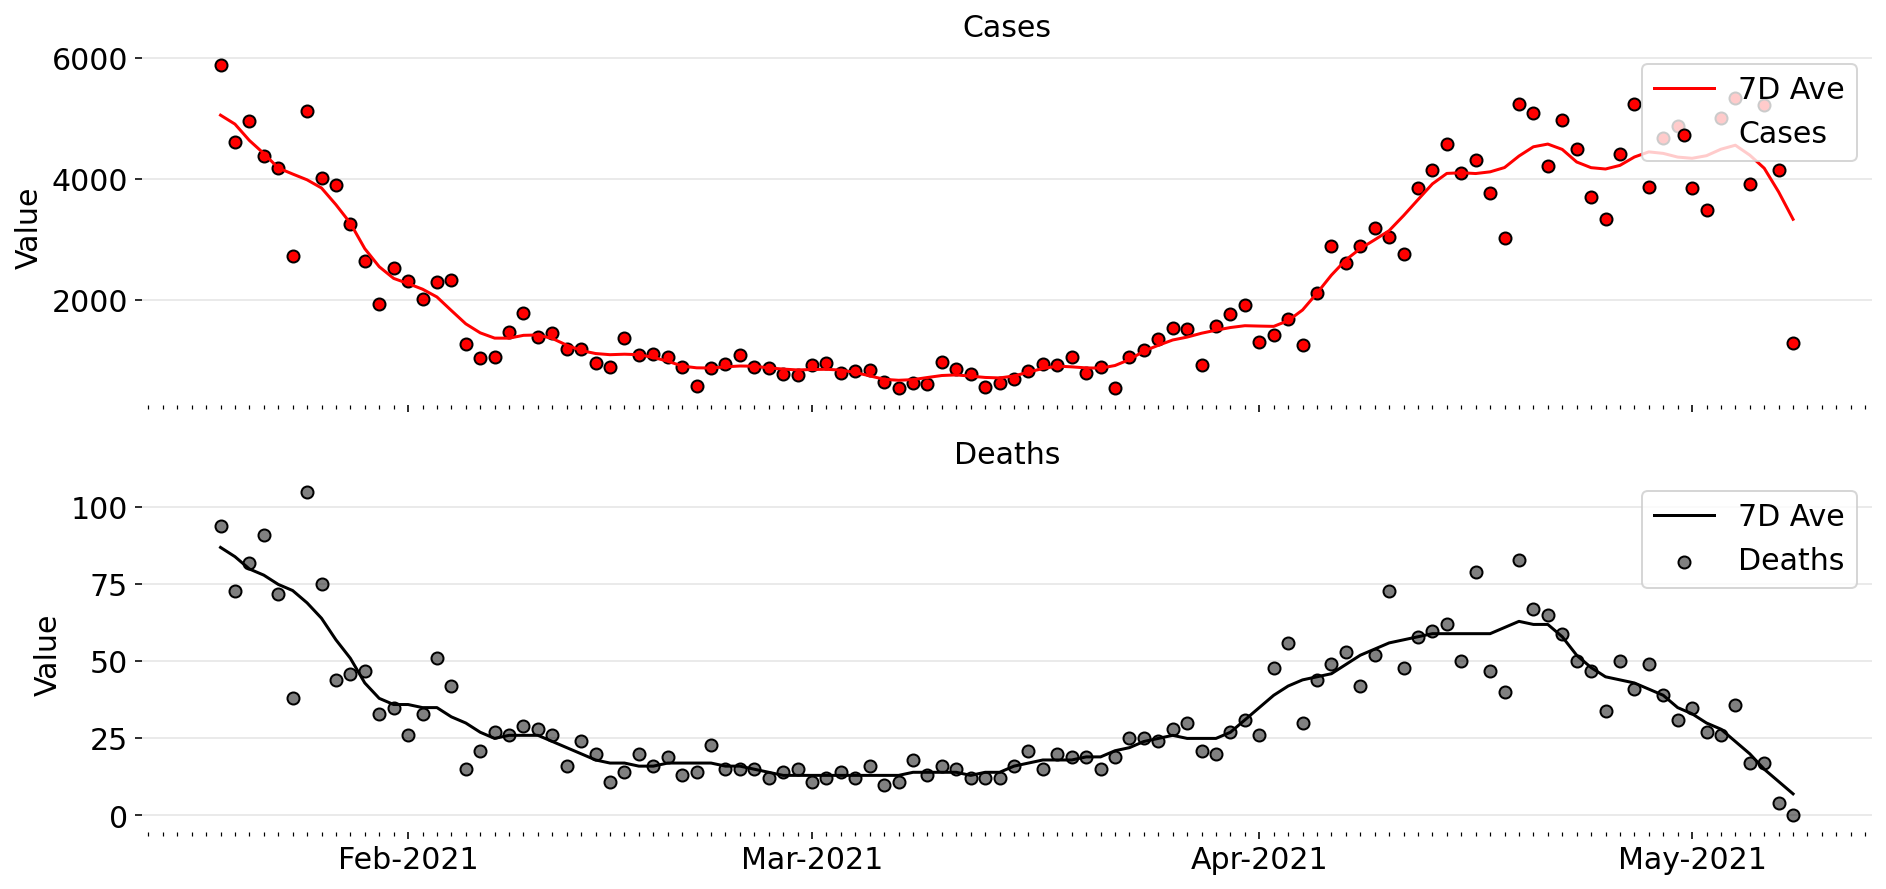

In [247]:

fig, axes = plt.subplots(2, 1, figsize=(15.5, 7.2), sharex=True)
axes[0].scatter(data_eval_plt.index.values, data_eval_plt["num_cases"], facecolor='r', edgecolor='k',  label='Cases')
axes[1].scatter(data_eval_plt.index.values, data_eval_plt["num_diseased"], facecolor='gray', edgecolor='k', label='Deaths')

axes[0].plot(data_eval_plt.index.values, data_eval_plt["smoothed_num_cases"], color='r',  label='7D Ave')
axes[1].plot(data_eval_plt.index.values, data_eval_plt["smoothed_num_diseased"], color='k',  label='7D Ave')


axes[0].set_title('Cases', fontsize=15)
axes[1].set_title('Deaths', fontsize=15)

axes[0].legend()
axes[1].legend()
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.set_ylabel('Value', size=15)
    ax.tick_params(which='both', axis='both', labelrotation=0, labelsize=15)
    #ax.set_ylim( (y1_l, y_lim_up) )
    ax.legend(loc='upper right', fontsize=15)
fig.savefig(os.path.join('figures_eval', f'data_eval.png'), dpi=300, bbox_inches='tight', transparent=False)
